In [116]:
import os
import torch
import requests
import numpy as np
import transformers
from PIL import Image
import torch.nn as nn
import skimage.io as io
from tqdm.auto import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [30]:
import configs

configs.set_seed(42)
device = configs.set_device(2)

There are 8 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-80GB


# dataset preprocessing for CLIP

In [117]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
import os


(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()


image_paths = []
labels = []

save_dir = 'cifar100_images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [118]:
for i in range(len(train_images)):
    image_path = os.path.join(save_dir, f"train_image_{i}.jpg")
    tf.keras.preprocessing.image.save_img(image_path, train_images[i])
    image_paths.append(image_path)
    labels.append(train_labels[i][0])


for i in range(len(test_images)):
    image_path = os.path.join(save_dir, f"test_image_{i}.jpg")
    tf.keras.preprocessing.image.save_img(image_path, test_images[i])
    image_paths.append(image_path)
    labels.append(test_labels[i][0])

In [119]:
print(len(train_images), "\n")
print(len(test_images), "\n")
print(len(image_paths))

50000 

10000 

60000


In [120]:
for i in range(len(image_paths)):
    print(f"{image_paths[i]} - Label: {labels[i]}")
    break

cifar100_images/train_image_0.jpg - Label: 19


In [8]:
classes = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}

In [9]:
labels[59000]

8

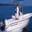

In [10]:
from PIL import Image
Image.open(image_paths[59000])

convert labels to textual data


In [ ]:
titles = []
for im in tqdm(range(len(image_paths))):
    titles.append(classes[labels[im]])

In [ ]:
assert len(titles) == len(labels) == len(image_paths)
assert titles[59000] == 'ship'
titles[59000]

concepts

In [59]:
def remove_prefixes(strings):
    prefixes = ['a', 'an', 'the']
    result = []

    for string in strings:
        words = string.split()
        if words[0].lower() in prefixes:
            result.append(' '.join(words[1:]))
        else:
            result.append(string)

    return result

with open("conceptnet_cifar10_filtered_new.txt", "r") as f:
    concepts = f.read().lower().split("\n")
    concepts = remove_prefixes(concepts)

In [ ]:
# WE WILL USE RANDOM WORDS NOW

In [13]:
from random_word import RandomWords
randword = RandomWords()

In [14]:
concepts = [randword.get_random_word() for _ in tqdm(range(3000))]

  0%|          | 0/3000 [00:00<?, ?it/s]

# CLIPDataset

collate_fn could be good for trainer but later

In [121]:
class CLIPDataset():
    def __init__(self, list_image_path, list_txt):
        self.image_path = list_image_path
        self.title  = list_txt

    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):
        image = Image.open(self.image_path[idx])
        title = self.title[idx]
        return image, title


def collate_fn(batch):
    return {
        'image': [x[0] for x in batch],
        'title': [x[1] for x in batch]
    }

dataset = CLIPDataset(list_image_path=image_paths, list_txt=labels) # but it can be with <<titles>> to get textual annotations for class labels
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [50000, 3000, 7000])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn, pin_memory=True)

In [122]:
assert len(dataset) == len(image_paths)
len(dataset)

60000

In [123]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [50000, 3000, 7000])
print("Train set: {}".format(len(train_dataset)), "\n")
print("Validation set: {}".format(len(val_dataset)), "\n")
print("Test set: {}".format(len(test_dataset)))

Train set: 50000 

Validation set: 3000 

Test set: 7000


test func

In [18]:
train_dataset[0]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=32x32>, 1)

In [ ]:
def collate_fn_test(sample):
    return {
        'image': sample[0],
        'title': sample[1]
    }

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

preprocessing dataloaders

In [19]:
from transformers import CLIPModel, CLIPProcessor, AutoTokenizer

def preprocess_loader(loader, concepts: list=concepts):
    preprocessed_batches = []
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    for batch in tqdm(loader):
        preprocessed_batch = preprocess_batch(batch, processor, concepts)
        preprocessed_batches.append(preprocessed_batch)
    return preprocessed_batches

def preprocess_batch(batch, processor, concepts: list=concepts):
    return processor(text=concepts, images=batch['image'], return_tensors="pt", padding=True), batch['title']

In [20]:
train_loader_preprocessed = preprocess_loader(train_loader, concepts)

  0%|          | 0/1563 [00:00<?, ?it/s]

In [21]:
val_loader_preprocessed = preprocess_loader(val_loader, concepts)

  0%|          | 0/94 [00:00<?, ?it/s]

In [22]:
test_loader_preprocessed = preprocess_loader(test_loader, concepts)

  0%|          | 0/219 [00:00<?, ?it/s]

# Model

In [ ]:
from transformers import CLIPConfig, CLIPTextConfig, CLIPVisionConfig

config_text = CLIPTextConfig()
config_vision = CLIPVisionConfig()
model_configuration = CLIPConfig.from_text_vision_configs(config_text, config_vision)
model_configuration

In [ ]:
from transformers import CLIPModel, CLIPProcessor, AutoTokenizer

model = CLIPModel(model_configuration).from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

In [136]:
class TuningCLIPhead(nn.Module):
    def __init__(self, model_name: str="openai/clip-vit-base-patch32", concepts: list=concepts, classes: dict=classes):
        super().__init__()
        self.clip = transformers.CLIPModel.from_pretrained(model_name)
        self.processor = transformers.CLIPProcessor.from_pretrained(model_name)
        for param in self.clip.parameters():
            param.requires_grad=False
        self.head = nn.Linear(len(concepts), len(classes), bias=False)

    def forward(self, **batch):
        out = self.clip(**batch).logits_per_image
        return self.head(out)

In [36]:
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

# Training

## try vanilla

In [35]:
clf = TuningCLIPhead()
optimizer = torch.optim.Adam(clf.parameters(), lr=1e-3)

In [37]:
loss_fn = torch.nn.CrossEntropyLoss()

In [38]:
epochs = 4
clf.to(device)
for epoch in range(epochs):
    for i, batch in enumerate(tqdm(train_loader_preprocessed)):
        optimizer.zero_grad()

        inputs, titles = batch
        inputs = inputs.to(device)
        logits = clf(**inputs).squeeze(0)
        targets = torch.tensor(titles, dtype=torch.long)
        loss = loss_fn(logits, targets.to(device))

        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(train_loader_preprocessed)}], Loss: {loss.item()}')


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [1/4], Batch [100/1563], Loss: 56.08104705810547
Epoch [1/4], Batch [200/1563], Loss: 27.034509658813477
Epoch [1/4], Batch [300/1563], Loss: 20.139663696289062
Epoch [1/4], Batch [400/1563], Loss: 15.874890327453613
Epoch [1/4], Batch [500/1563], Loss: 8.777186393737793
Epoch [1/4], Batch [600/1563], Loss: 5.055863380432129
Epoch [1/4], Batch [700/1563], Loss: 8.201421737670898
Epoch [1/4], Batch [800/1563], Loss: 5.2801513671875
Epoch [1/4], Batch [900/1563], Loss: 9.778894424438477
Epoch [1/4], Batch [1000/1563], Loss: 6.301056385040283
Epoch [1/4], Batch [1100/1563], Loss: 3.8661715984344482
Epoch [1/4], Batch [1200/1563], Loss: 5.973512172698975
Epoch [1/4], Batch [1300/1563], Loss: 4.831838607788086
Epoch [1/4], Batch [1400/1563], Loss: 3.671333074569702
Epoch [1/4], Batch [1500/1563], Loss: 1.2460362911224365


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [2/4], Batch [100/1563], Loss: 3.8366637229919434
Epoch [2/4], Batch [200/1563], Loss: 5.821336269378662
Epoch [2/4], Batch [300/1563], Loss: 5.521483898162842
Epoch [2/4], Batch [400/1563], Loss: 2.1065967082977295
Epoch [2/4], Batch [500/1563], Loss: 12.648907661437988
Epoch [2/4], Batch [600/1563], Loss: 6.512814044952393
Epoch [2/4], Batch [700/1563], Loss: 8.308746337890625
Epoch [2/4], Batch [800/1563], Loss: 4.8472466468811035
Epoch [2/4], Batch [900/1563], Loss: 14.418810844421387
Epoch [2/4], Batch [1000/1563], Loss: 4.699795246124268
Epoch [2/4], Batch [1100/1563], Loss: 4.706864833831787
Epoch [2/4], Batch [1200/1563], Loss: 1.6985911130905151
Epoch [2/4], Batch [1300/1563], Loss: 5.514067649841309
Epoch [2/4], Batch [1400/1563], Loss: 2.1454920768737793
Epoch [2/4], Batch [1500/1563], Loss: 12.727208137512207


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [3/4], Batch [100/1563], Loss: 9.44974422454834
Epoch [3/4], Batch [200/1563], Loss: 4.0968170166015625
Epoch [3/4], Batch [300/1563], Loss: 4.701021194458008
Epoch [3/4], Batch [400/1563], Loss: 6.301344394683838
Epoch [3/4], Batch [500/1563], Loss: 5.061450004577637
Epoch [3/4], Batch [600/1563], Loss: 0.43600788712501526
Epoch [3/4], Batch [700/1563], Loss: 22.6287841796875
Epoch [3/4], Batch [800/1563], Loss: 6.28128719329834
Epoch [3/4], Batch [900/1563], Loss: 6.97457218170166
Epoch [3/4], Batch [1000/1563], Loss: 8.541454315185547
Epoch [3/4], Batch [1100/1563], Loss: 7.728588104248047
Epoch [3/4], Batch [1200/1563], Loss: 4.394205093383789
Epoch [3/4], Batch [1300/1563], Loss: 2.1739702224731445
Epoch [3/4], Batch [1400/1563], Loss: 3.8886220455169678
Epoch [3/4], Batch [1500/1563], Loss: 9.492695808410645


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [4/4], Batch [100/1563], Loss: 5.064755916595459
Epoch [4/4], Batch [200/1563], Loss: 2.406501054763794
Epoch [4/4], Batch [300/1563], Loss: 8.023077964782715
Epoch [4/4], Batch [400/1563], Loss: 1.0844647884368896
Epoch [4/4], Batch [500/1563], Loss: 10.73427963256836
Epoch [4/4], Batch [600/1563], Loss: 3.0541880130767822
Epoch [4/4], Batch [700/1563], Loss: 4.285129547119141
Epoch [4/4], Batch [800/1563], Loss: 2.9247593879699707
Epoch [4/4], Batch [900/1563], Loss: 7.987706661224365
Epoch [4/4], Batch [1000/1563], Loss: 4.766819953918457
Epoch [4/4], Batch [1100/1563], Loss: 5.068933010101318
Epoch [4/4], Batch [1200/1563], Loss: 9.829794883728027
Epoch [4/4], Batch [1300/1563], Loss: 7.916134834289551
Epoch [4/4], Batch [1400/1563], Loss: 4.2021026611328125
Epoch [4/4], Batch [1500/1563], Loss: 4.333529949188232


In [ ]:
import datasets

metric = datasets.load_metric("accuracy")

clf.eval()
with torch.no_grad():
    all_preds = []
    all_labels = []
    for batch in tqdm(test_loader_preprocessed):
        inputs, titles = batch
        inputs = inputs.to(device)
        logits = clf(**inputs).squeeze(0)
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(titles)

metric.compute(predictions=all_preds, references=all_labels)
clf.train()

In [40]:
metric.compute(predictions=all_preds, references=all_labels)

{'accuracy': 0.745}

In [ ]:
torch.save(clf.state_dict(), '/content/saved_cbm_0774')

# try all concepts

In [45]:
with open("all_concepts.txt", "r") as f:
    all_concepts = f.read().lower().split("\n")
    all_concepts = remove_prefixes(all_concepts)

In [46]:
train_loader_preprocessed = preprocess_loader(train_loader, all_concepts)
val_loader_preprocessed = preprocess_loader(val_loader, all_concepts)
test_loader_preprocessed = preprocess_loader(test_loader, all_concepts)

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

In [54]:
clf = TuningCLIPhead(concepts=all_concepts)
optimizer = torch.optim.Adam(clf.parameters(), lr=1e-3)

for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)
            
loss_fn = torch.nn.CrossEntropyLoss()
print("Number of parameters: ", sum(p.numel() for p in clf.parameters()))

Number of parameters:  151327823


In [55]:
print("Number of trainable parameters is: {}".format(sum(p.numel() for p in clf.parameters() if p.requires_grad == True)))

Number of trainable parameters is: 50510


In [56]:
epochs = 4
clf.to(device)
for epoch in tqdm(range(epochs)):
    for i, batch in enumerate(tqdm(train_loader_preprocessed)):
        optimizer.zero_grad()

        inputs, titles = batch
        inputs = inputs.to(device)
        logits = clf(**inputs).squeeze(0)
        targets = torch.tensor(titles, dtype=torch.long)
        loss = loss_fn(logits, targets.to(device))

        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(train_loader_preprocessed)}], Loss: {loss.item()}')


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [1/4], Batch [100/1563], Loss: 37.88859176635742
Epoch [1/4], Batch [200/1563], Loss: 21.03249168395996
Epoch [1/4], Batch [300/1563], Loss: 25.862337112426758
Epoch [1/4], Batch [400/1563], Loss: 11.982831001281738
Epoch [1/4], Batch [500/1563], Loss: 11.091796875
Epoch [1/4], Batch [600/1563], Loss: 14.489102363586426
Epoch [1/4], Batch [700/1563], Loss: 5.76395845413208
Epoch [1/4], Batch [800/1563], Loss: 4.724400043487549
Epoch [1/4], Batch [900/1563], Loss: 13.381888389587402
Epoch [1/4], Batch [1000/1563], Loss: 6.975177764892578
Epoch [1/4], Batch [1100/1563], Loss: 5.489748954772949
Epoch [1/4], Batch [1200/1563], Loss: 5.656094551086426
Epoch [1/4], Batch [1300/1563], Loss: 3.9462225437164307
Epoch [1/4], Batch [1400/1563], Loss: 4.940522193908691
Epoch [1/4], Batch [1500/1563], Loss: 11.017729759216309


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [2/4], Batch [100/1563], Loss: 8.160943984985352
Epoch [2/4], Batch [200/1563], Loss: 8.93914794921875
Epoch [2/4], Batch [300/1563], Loss: 8.673338890075684
Epoch [2/4], Batch [400/1563], Loss: 3.4703125953674316
Epoch [2/4], Batch [500/1563], Loss: 7.444727420806885
Epoch [2/4], Batch [600/1563], Loss: 7.4904069900512695
Epoch [2/4], Batch [700/1563], Loss: 11.316879272460938
Epoch [2/4], Batch [800/1563], Loss: 3.5226500034332275
Epoch [2/4], Batch [900/1563], Loss: 9.334565162658691
Epoch [2/4], Batch [1000/1563], Loss: 4.993555068969727
Epoch [2/4], Batch [1100/1563], Loss: 11.50049114227295
Epoch [2/4], Batch [1200/1563], Loss: 5.546926021575928
Epoch [2/4], Batch [1300/1563], Loss: 14.380863189697266
Epoch [2/4], Batch [1400/1563], Loss: 12.728438377380371
Epoch [2/4], Batch [1500/1563], Loss: 10.744918823242188


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [3/4], Batch [100/1563], Loss: 8.99299144744873
Epoch [3/4], Batch [200/1563], Loss: 6.965775966644287
Epoch [3/4], Batch [300/1563], Loss: 8.306268692016602
Epoch [3/4], Batch [400/1563], Loss: 5.321594715118408
Epoch [3/4], Batch [500/1563], Loss: 4.352184772491455
Epoch [3/4], Batch [600/1563], Loss: 11.21856689453125
Epoch [3/4], Batch [700/1563], Loss: 7.3363728523254395
Epoch [3/4], Batch [800/1563], Loss: 6.972843647003174
Epoch [3/4], Batch [900/1563], Loss: 5.909428119659424
Epoch [3/4], Batch [1000/1563], Loss: 2.224576234817505
Epoch [3/4], Batch [1100/1563], Loss: 8.593094825744629
Epoch [3/4], Batch [1200/1563], Loss: 4.711339950561523
Epoch [3/4], Batch [1300/1563], Loss: 5.950993061065674
Epoch [3/4], Batch [1400/1563], Loss: 7.912385940551758
Epoch [3/4], Batch [1500/1563], Loss: 9.78282642364502


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [4/4], Batch [100/1563], Loss: 11.410944938659668
Epoch [4/4], Batch [200/1563], Loss: 10.829590797424316
Epoch [4/4], Batch [300/1563], Loss: 4.158377170562744
Epoch [4/4], Batch [400/1563], Loss: 6.279514312744141
Epoch [4/4], Batch [500/1563], Loss: 4.621114253997803
Epoch [4/4], Batch [600/1563], Loss: 8.496142387390137
Epoch [4/4], Batch [700/1563], Loss: 3.2569098472595215
Epoch [4/4], Batch [800/1563], Loss: 8.445197105407715
Epoch [4/4], Batch [900/1563], Loss: 9.746769905090332
Epoch [4/4], Batch [1000/1563], Loss: 1.34959077835083
Epoch [4/4], Batch [1100/1563], Loss: 5.229201793670654
Epoch [4/4], Batch [1200/1563], Loss: 5.1395463943481445
Epoch [4/4], Batch [1300/1563], Loss: 19.07879638671875
Epoch [4/4], Batch [1400/1563], Loss: 9.898480415344238
Epoch [4/4], Batch [1500/1563], Loss: 16.251388549804688


In [57]:
clf.eval()
with torch.no_grad():
    all_preds = []
    all_labels = []
    for batch in tqdm(test_loader_preprocessed):
        inputs, titles = batch
        inputs = inputs.to(device)
        logits = clf(**inputs).squeeze(0)
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(titles)

metric.compute(predictions=all_preds, references=all_labels)

  0%|          | 0/219 [00:00<?, ?it/s]

{'accuracy': 0.7054285714285714}

# concepts

In [128]:
torch.cuda.empty_cache()

In [94]:
clf = TuningCLIPhead(concepts=concepts)
optimizer = torch.optim.Adam(clf.parameters(), lr=1e-3)

for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)
            
loss_fn = torch.nn.CrossEntropyLoss()
print("Number of parameters: ", sum(p.numel() for p in clf.parameters()), "\n")
print("Number of trainable parameters is: {}".format(sum(p.numel() for p in clf.parameters() if p.requires_grad == True)))

Number of parameters:  151278513 

Number of trainable parameters is: 1200


In [68]:
import os
import json
import pandas as pd
from typing import Union
import matplotlib.pyplot as plt

class TrainerLogger:
    def __init__(self, logging_dir: Union[str, None]=None):
        self.logging_dir = logging_dir
        if logging_dir != None:
            os.makedirs(self.logging_dir, exist_ok=True)
        self.history = {"epoch": [], "Loss/Train": [], "Loss/Validation": [], "Accuracy/Validation": [], "Accuracy/Test": []}

    def log(self, values):
        for key, value in values.items():
            if key in self.history:
                self.history[key].append(value)
            else:
                self.history[key] = [value]
                
        self.save_to_json("history")

    def save_to_json(self, filename):
        if self.logging_dir is not None:
            filepath = os.path.join(self.logging_dir, f"{filename}.json")
            with open(filepath, 'w') as json_file:
                json.dump(self.history, json_file)

    def plot_summary(self, key):
        if key not in self.history:
            print(f"Key '{key}' not found in history.")
            return

        if key == "Accuracy/Test":
            df = pd.DataFrame({key: [key], 'Percentage': self.history[key]})
            ax = df.plot.barh(x=key, y='Percentage')
            ax.set_xlim(0, 1)
            ax.set_xlabel("Percentage")
            ax.set_title("Accuracy/Test", fontsize=20)
            plt.show()
        else:
            fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
            plt.plot(self.history["epoch"], self.history[key], label=key)
            ax.set_title(f"{key}", fontsize=20)
            ax.set_xlabel("Epochs", fontsize=20)
            if key not in ["epoch", "Accuracy/Validation"]:
                ax.set_ylabel("loss", fontsize=20)
            else:
                ax.set_ylabel(key, fontsize=20)
            ax.legend()
            ax.set_xlim(left=0)
            ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
            ax.grid(False)
            plt.show()

In [69]:
@torch.no_grad()
@torch.cuda.amp.autocast()
def val_loss_accuracy(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    val_losses = []
    for batch in tqdm(loader):
        inputs, labels = batch
        inputs = inputs.to(device)

        logits = model(**inputs).squeeze(0)
        targets = torch.tensor(labels, dtype=torch.long)
        loss = criterion(logits, targets.to(device))
        val_losses.append(loss.item())
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels)

    val_accuracy = metric.compute(predictions=all_preds, references=all_labels)
    avg_val_loss = sum(val_losses) / len(val_losses)

    return val_accuracy, avg_val_loss

@torch.no_grad()
@torch.cuda.amp.autocast()
def get_test_accuracy(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    for batch in tqdm(loader):
        inputs, labels = batch
        inputs = inputs.to(device)

        logits = model(**inputs).squeeze(0)
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels)

    test_accuracy = metric.compute(predictions=all_preds, references=all_labels)

    return test_accuracy

In [71]:
train_loader_preprocessed = preprocess_loader(train_loader, concepts)
val_loader_preprocessed = preprocess_loader(val_loader, concepts)
test_loader_preprocessed = preprocess_loader(test_loader, concepts)

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

In [95]:
criterion = torch.nn.CrossEntropyLoss()

In [96]:
num_epochs = 15
clf.to(device)
logger = TrainerLogger("./cbm-raw")

for epoch in range(num_epochs):
    clf.train()
    for batch in tqdm(train_loader_preprocessed, desc=f"Epoch {epoch + 1}/ {num_epochs}"):
        optimizer.zero_grad()

        inputs, labels = batch
        inputs = inputs.to(device)
        logits = clf(**inputs).squeeze(0)
        targets = torch.tensor(labels, dtype=torch.long)
        loss = criterion(logits, targets.to(device))

        loss.backward()
        optimizer.step()
        
    clf.eval()
    val_accuracy, avg_val_loss = val_loss_accuracy(clf, val_loader_preprocessed)
    logger.log({
        "epoch": epoch,
        "Loss/Train": loss.item(),
        "Loss/Validation": avg_val_loss,
        "Accuracy/Validation": val_accuracy['accuracy']
    })
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {loss.item()}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy}")
           
clf.eval()
test_accuracy = get_test_accuracy(clf, test_loader_preprocessed)
logger.log({"Accuracy/Test": test_accuracy['accuracy']})

Epoch 1/ 15:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1/15, Train Loss: 1.018005132675171, Validation Loss: 1.1593895909634042, Validation Accuracy: {'accuracy': 0.578}


Epoch 2/ 15:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2/15, Train Loss: 0.801660418510437, Validation Loss: 1.0814227969088452, Validation Accuracy: {'accuracy': 0.6176666666666667}


Epoch 3/ 15:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 3/15, Train Loss: 0.7308273315429688, Validation Loss: 1.0458668952292585, Validation Accuracy: {'accuracy': 0.6406666666666667}


Epoch 4/ 15:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 4/15, Train Loss: 0.7023510932922363, Validation Loss: 0.9876272034771899, Validation Accuracy: {'accuracy': 0.673}


Epoch 5/ 15:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 5/15, Train Loss: 0.6912358403205872, Validation Loss: 0.9253208979647211, Validation Accuracy: {'accuracy': 0.695}


Epoch 6/ 15:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 6/15, Train Loss: 0.6875377297401428, Validation Loss: 0.8756874419273214, Validation Accuracy: {'accuracy': 0.718}


Epoch 7/ 15:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 7/15, Train Loss: 0.6876305937767029, Validation Loss: 0.8416353372183252, Validation Accuracy: {'accuracy': 0.7273333333333334}


Epoch 8/ 15:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 8/15, Train Loss: 0.6915464401245117, Validation Loss: 0.8185165067936512, Validation Accuracy: {'accuracy': 0.7313333333333333}


Epoch 9/ 15:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 9/15, Train Loss: 0.698932409286499, Validation Loss: 0.8033929077234674, Validation Accuracy: {'accuracy': 0.7396666666666667}


Epoch 10/ 15:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 10/15, Train Loss: 0.7081724405288696, Validation Loss: 0.7939023106022084, Validation Accuracy: {'accuracy': 0.7416666666666667}


Epoch 11/ 15:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 11/15, Train Loss: 0.7172979116439819, Validation Loss: 0.7855319196873523, Validation Accuracy: {'accuracy': 0.7436666666666667}


Epoch 12/ 15:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 12/15, Train Loss: 0.7247225046157837, Validation Loss: 0.7783705370223268, Validation Accuracy: {'accuracy': 0.747}


Epoch 13/ 15:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 13/15, Train Loss: 0.7294933795928955, Validation Loss: 0.77319846096191, Validation Accuracy: {'accuracy': 0.7493333333333333}


Epoch 14/ 15:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 14/15, Train Loss: 0.7312646508216858, Validation Loss: 0.7663392757481717, Validation Accuracy: {'accuracy': 0.7516666666666667}


Epoch 15/ 15:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 15/15, Train Loss: 0.7301368117332458, Validation Loss: 0.760473409231673, Validation Accuracy: {'accuracy': 0.751}


  0%|          | 0/219 [00:00<?, ?it/s]

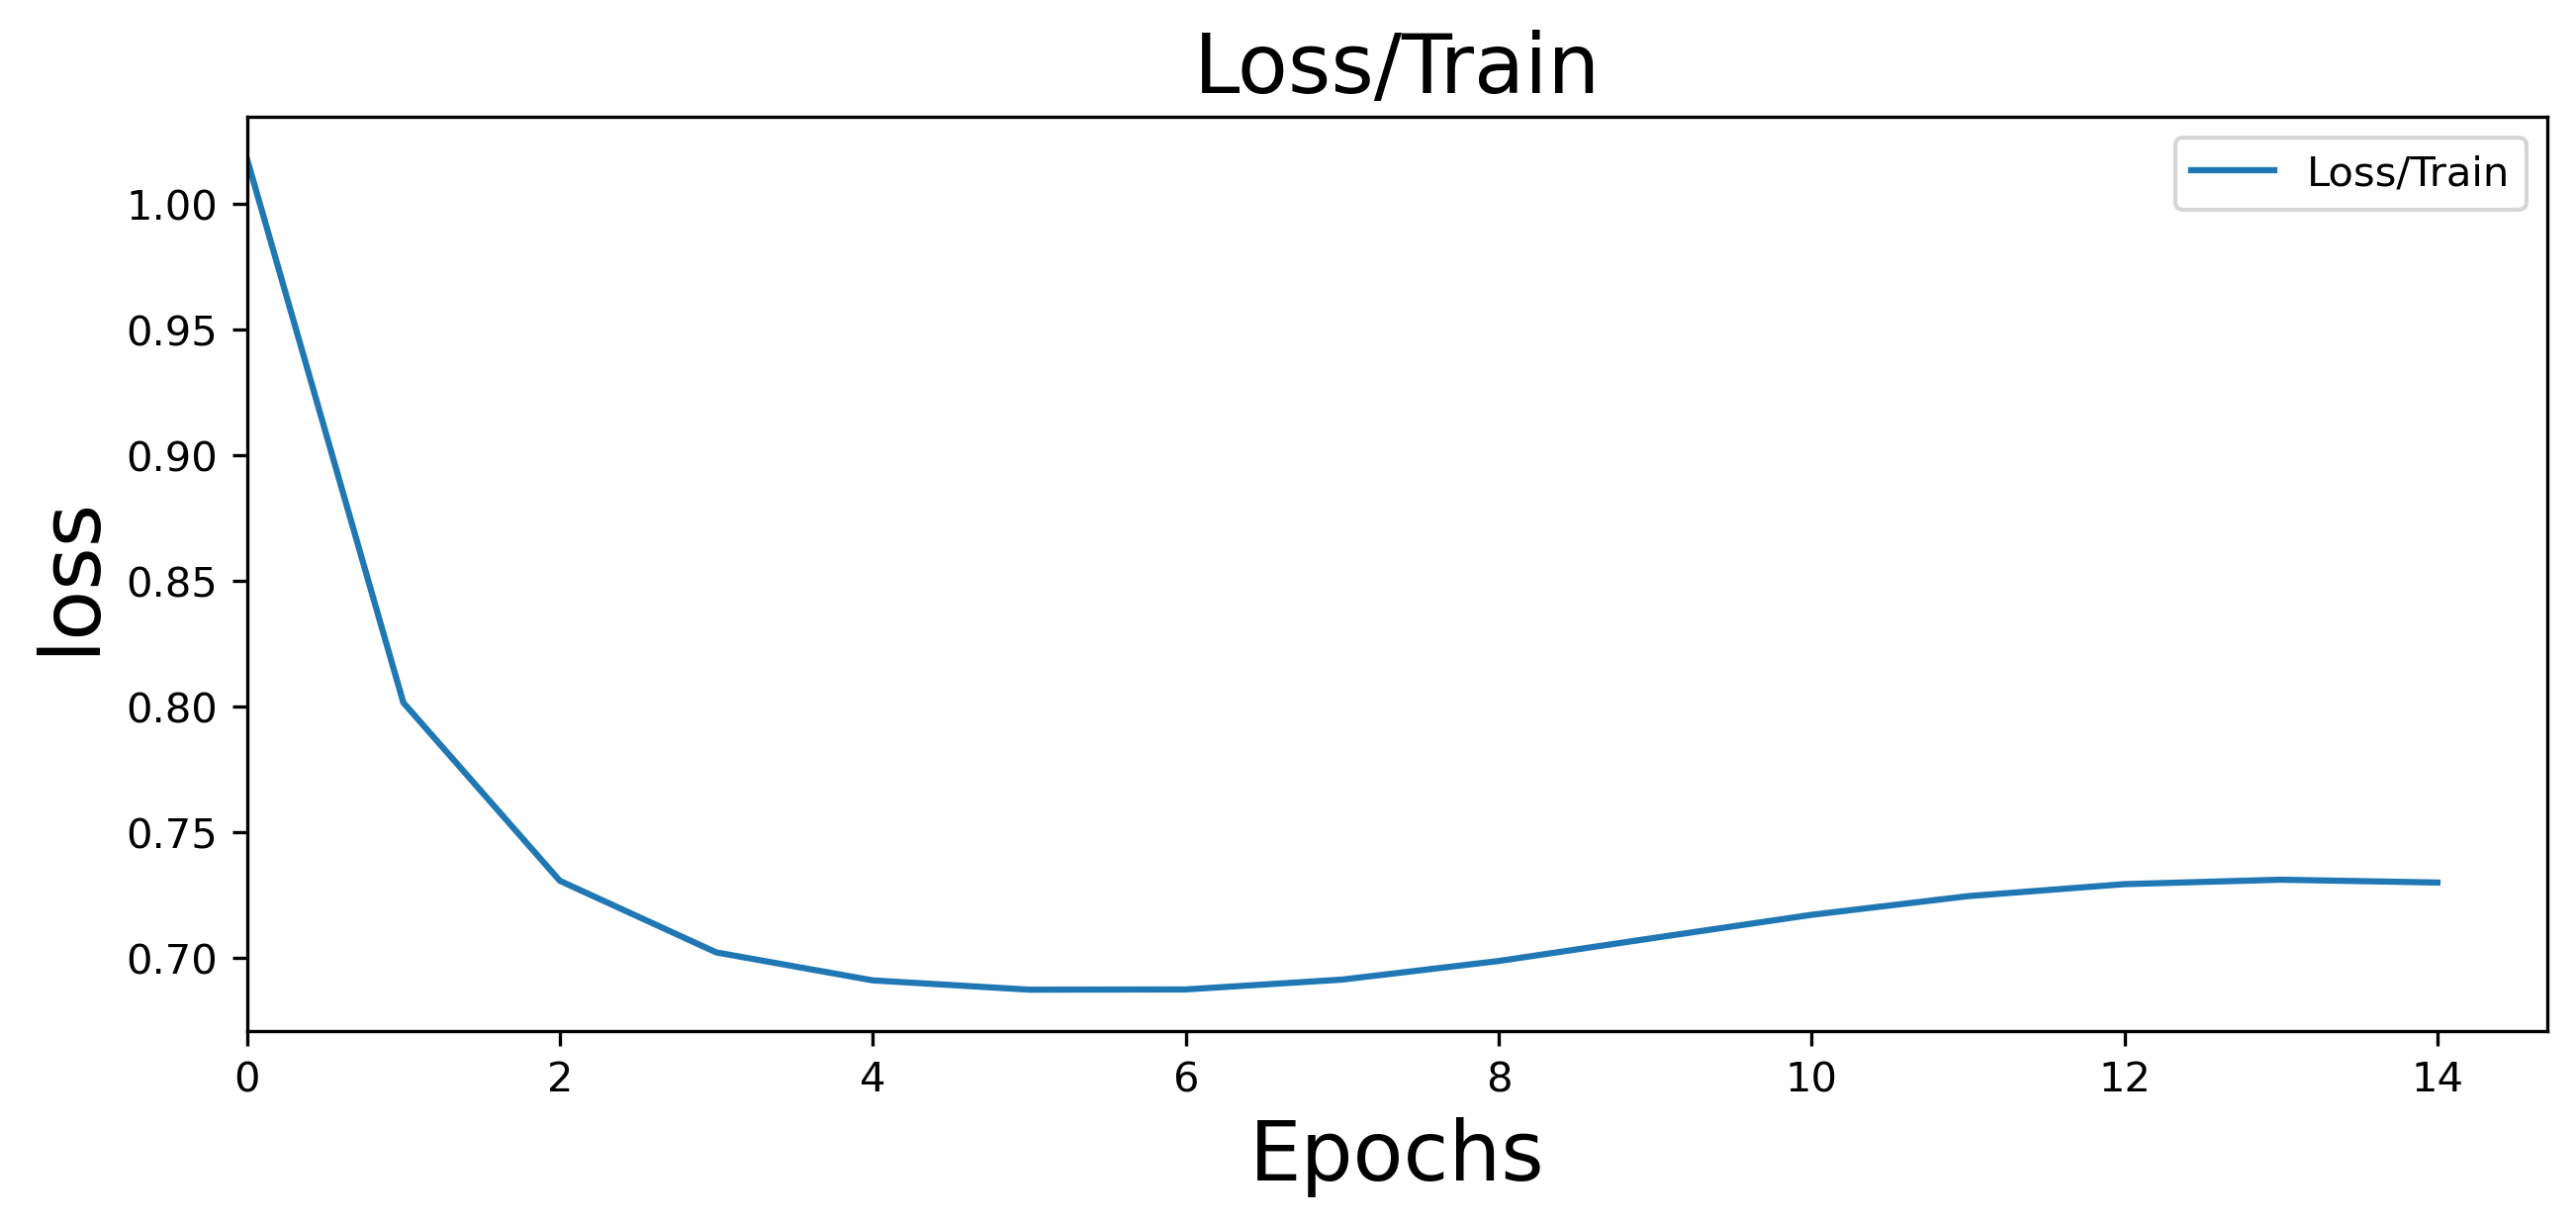

In [97]:
logger.plot_summary("Loss/Train")

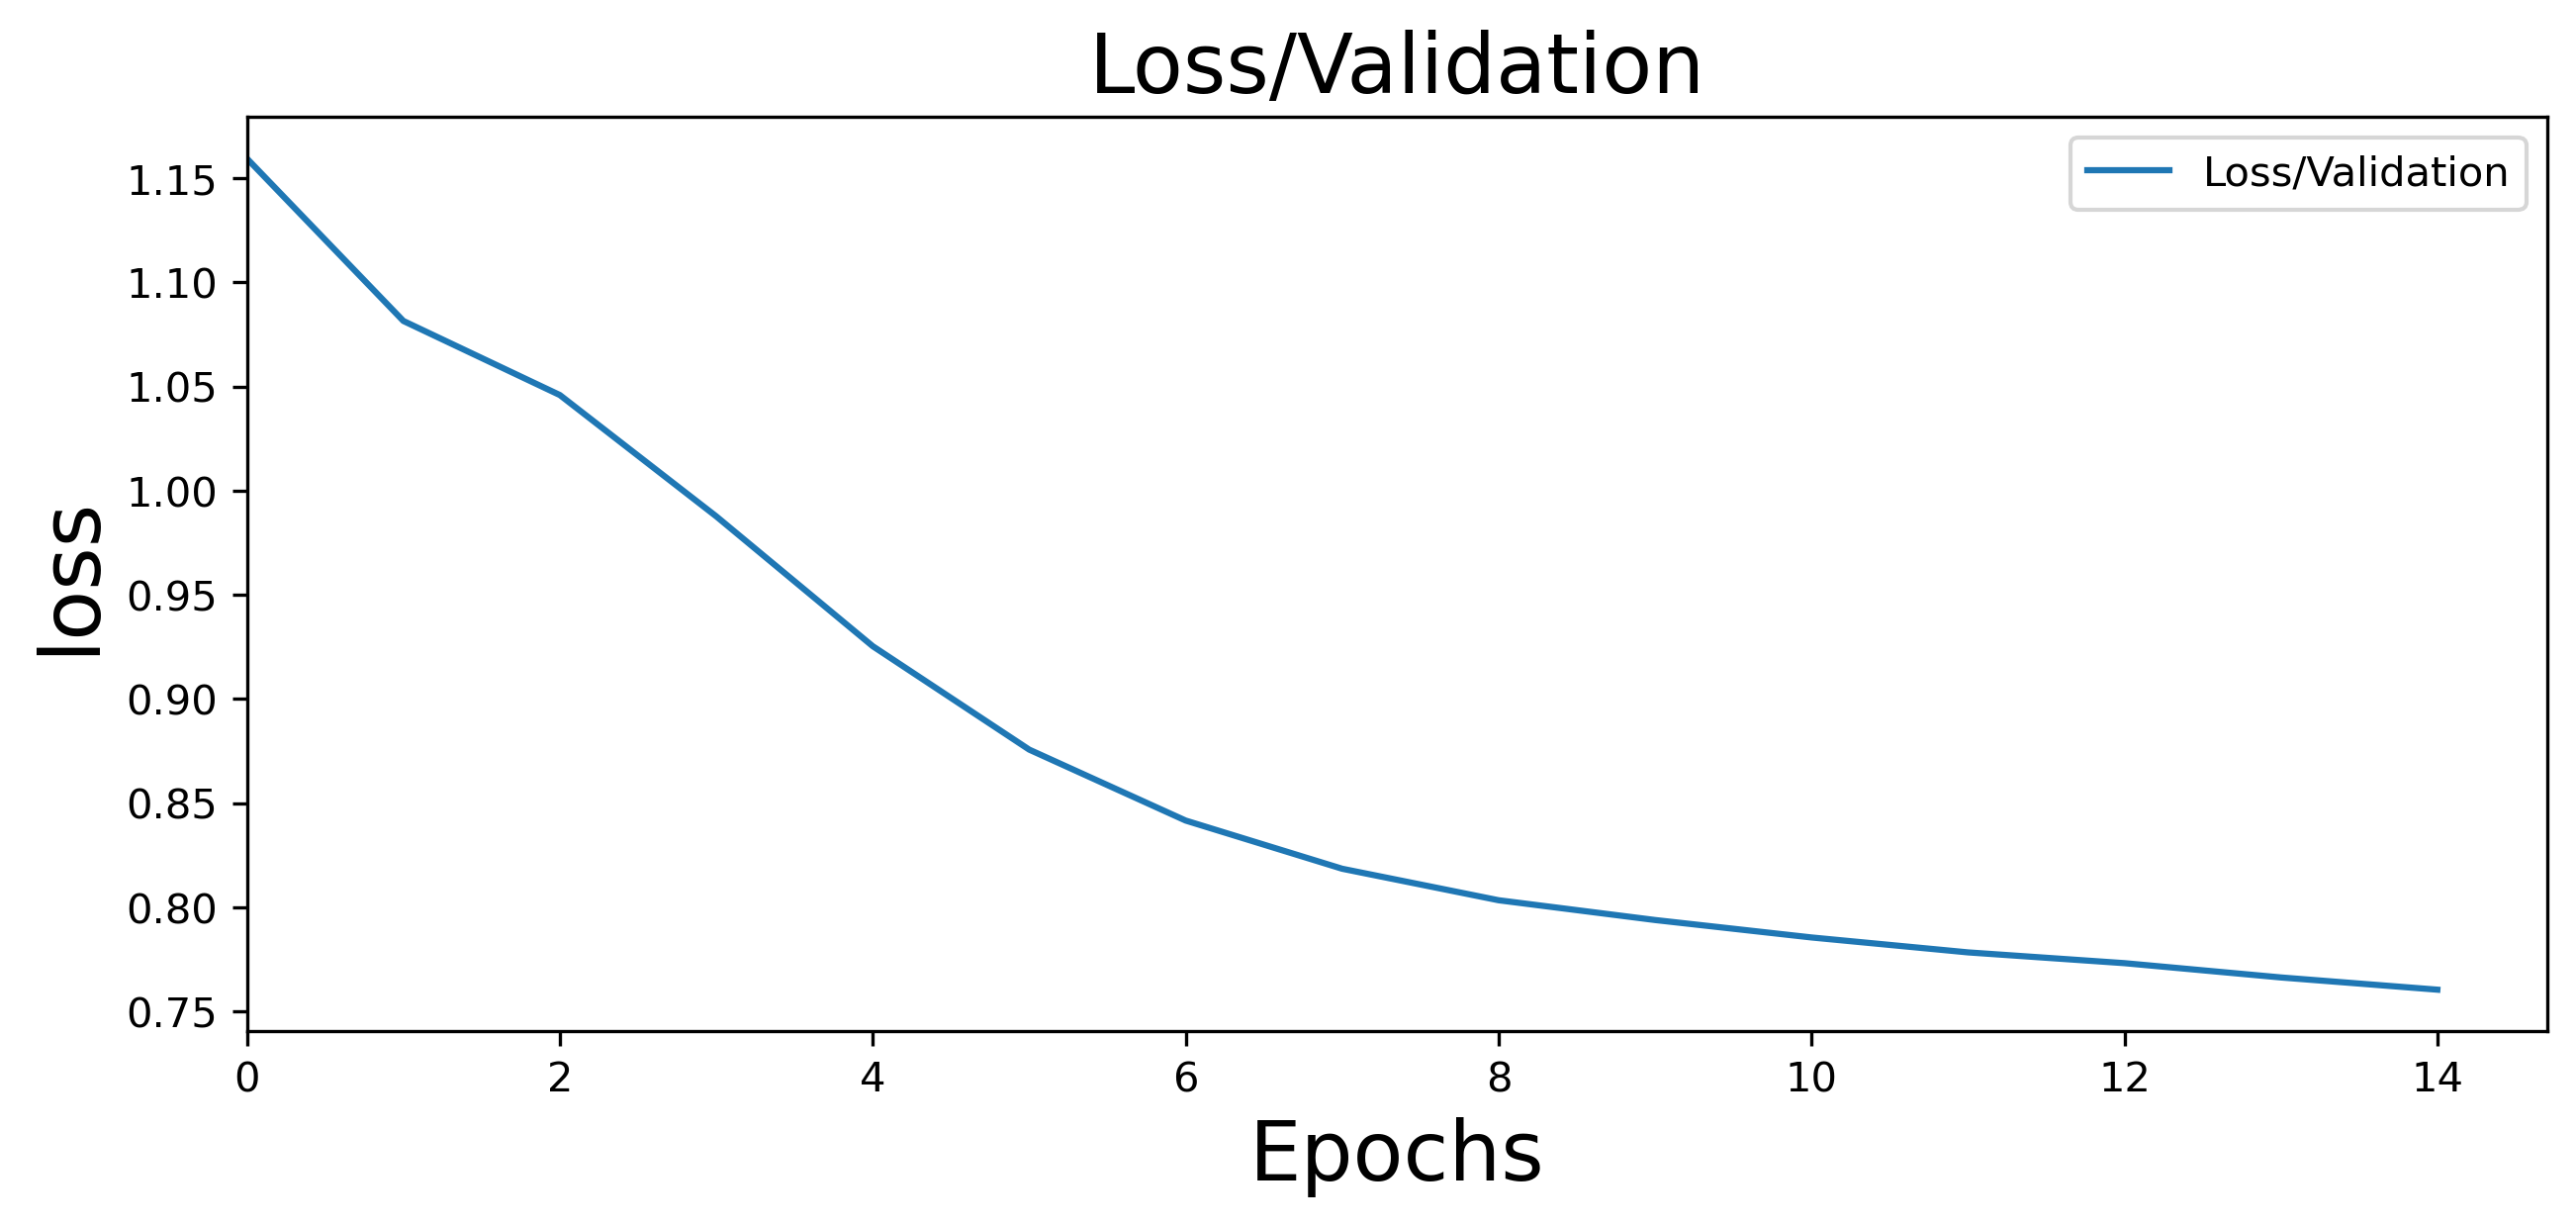

In [98]:
logger.plot_summary("Loss/Validation")

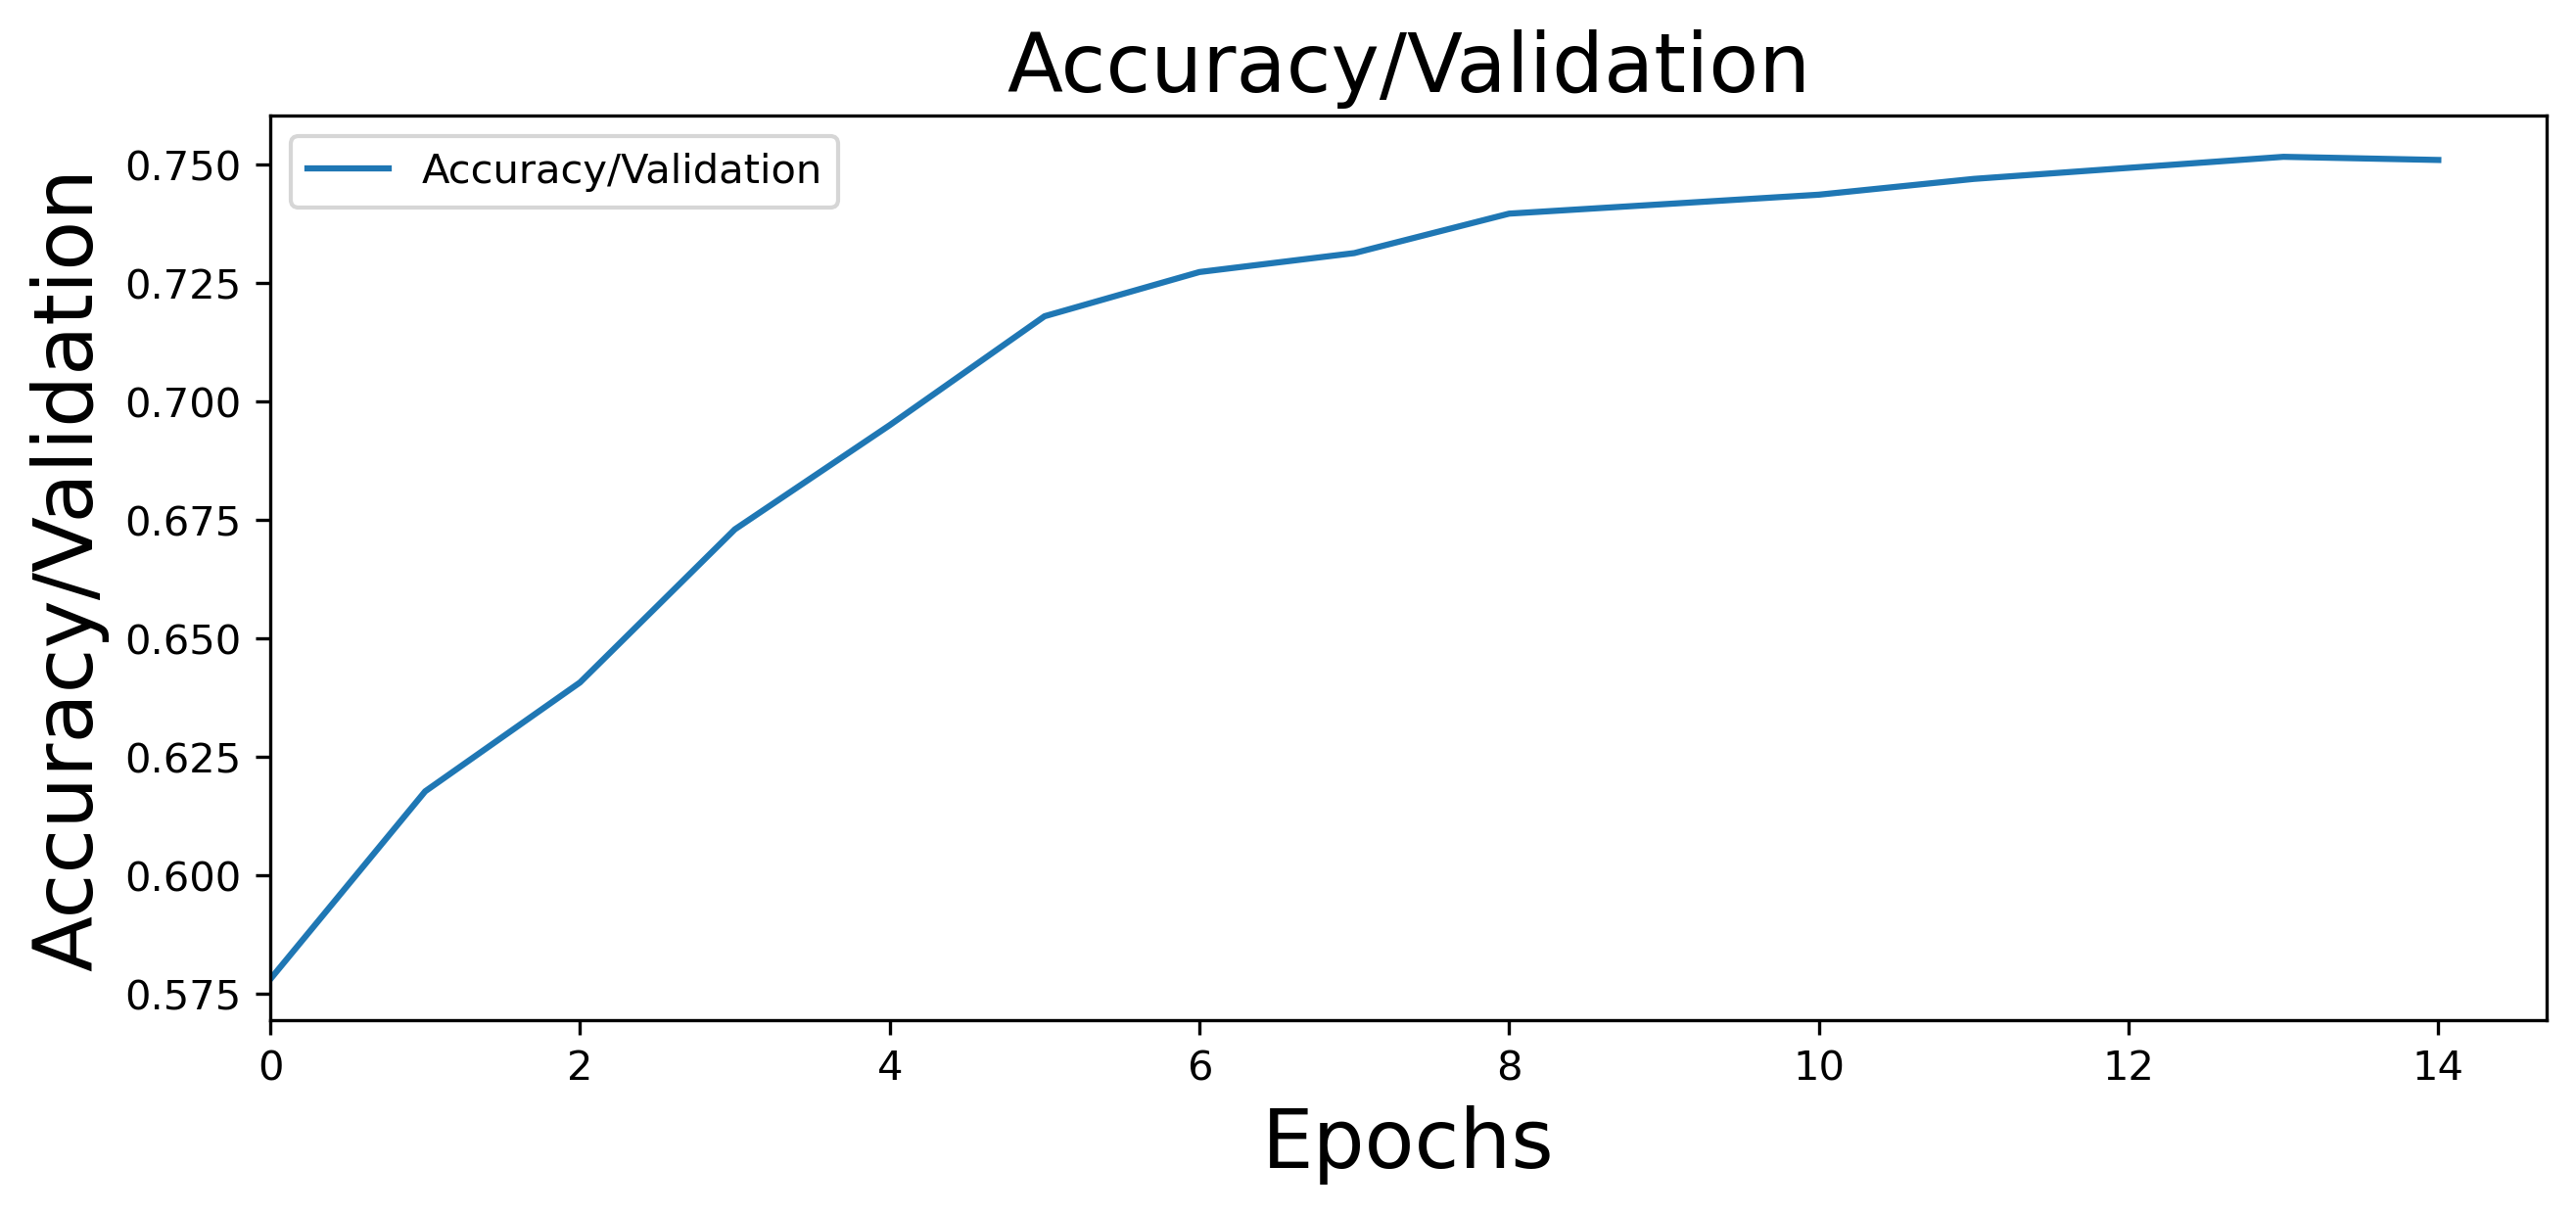

In [99]:
logger.plot_summary("Accuracy/Validation")

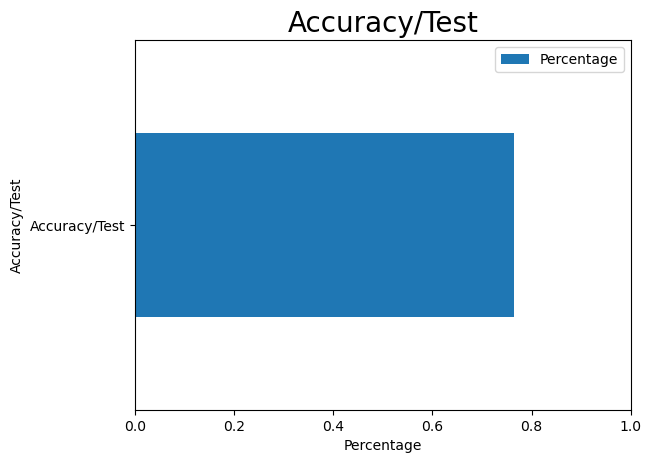

In [100]:
logger.plot_summary("Accuracy/Test")

# another dataset – CIFAR100

In [131]:
with open("conceptnet_cifar100_filtered_new.txt", "r") as f:
    concepts = f.read().lower().split("\n")
    concepts = remove_prefixes(concepts)

In [139]:
train_loader_preprocessed = preprocess_loader(train_loader, concepts)
val_loader_preprocessed = preprocess_loader(val_loader, concepts)
test_loader_preprocessed = preprocess_loader(test_loader, concepts)

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

In [129]:
cifar100_classes = {}
for i in range(100):
    cifar100_classes[i] = i

len(cifar100_classes)

100

In [145]:
clf = TuningCLIPhead(concepts=concepts, classes=cifar100_classes)
optimizer = torch.optim.Adam(clf.parameters(), lr=1e-3)

for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)
            
loss_fn = torch.nn.CrossEntropyLoss()
print("Number of parameters: ", sum(p.numel() for p in clf.parameters()), "\n")
print("Number of trainable parameters is: {}".format(sum(p.numel() for p in clf.parameters() if p.requires_grad == True)))

Number of parameters:  151371713 

Number of trainable parameters is: 94400


In [ ]:
num_epochs = 100
clf.to(device)
logger = TrainerLogger("./cbm-raw-cifar100")

for epoch in range(num_epochs):
    clf.train()
    for batch in tqdm(train_loader_preprocessed, desc=f"Epoch {epoch + 1}/ {num_epochs}"):
        optimizer.zero_grad()

        inputs, labels = batch
        inputs = inputs.to(device)
        logits = clf(**inputs).squeeze(0)
        targets = torch.tensor(labels, dtype=torch.long)
        loss = criterion(logits, targets.to(device))

        loss.backward()
        optimizer.step()
        
    clf.eval()
    val_accuracy, avg_val_loss = val_loss_accuracy(clf, val_loader_preprocessed)
    logger.log({
        "epoch": epoch,
        "Loss/Train": loss.item(),
        "Loss/Validation": avg_val_loss,
        "Accuracy/Validation": val_accuracy['accuracy']
    })
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {loss.item()}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy}")
           
clf.eval()
test_accuracy = get_test_accuracy(clf, test_loader_preprocessed)
logger.log({"Accuracy/Test": test_accuracy['accuracy']})

Epoch 1/ 100:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 10.234326362609863, Validation Loss: 15.253393487727388, Validation Accuracy: {'accuracy': 0.115}


Epoch 2/ 100:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2/100, Train Loss: 15.934325218200684, Validation Loss: 12.523649580935215, Validation Accuracy: {'accuracy': 0.219}


Epoch 3/ 100:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 3/100, Train Loss: 12.747123718261719, Validation Loss: 11.356596246678778, Validation Accuracy: {'accuracy': 0.218}


Epoch 4/ 100:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 4/100, Train Loss: 15.798138618469238, Validation Loss: 12.133240831659196, Validation Accuracy: {'accuracy': 0.22766666666666666}


Epoch 5/ 100:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 5/100, Train Loss: 19.83710289001465, Validation Loss: 13.855707554107017, Validation Accuracy: {'accuracy': 0.25033333333333335}


Epoch 6/ 100:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 6/100, Train Loss: 10.75800609588623, Validation Loss: 11.299174881995992, Validation Accuracy: {'accuracy': 0.219}


Epoch 7/ 100:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 7/100, Train Loss: 17.298044204711914, Validation Loss: 14.613097495221076, Validation Accuracy: {'accuracy': 0.21266666666666667}


Epoch 8/ 100:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 8/100, Train Loss: 20.210765838623047, Validation Loss: 13.820259312365918, Validation Accuracy: {'accuracy': 0.26866666666666666}


Epoch 9/ 100:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 9/100, Train Loss: 19.21257972717285, Validation Loss: 11.412909020768835, Validation Accuracy: {'accuracy': 0.299}


Epoch 10/ 100:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 10/100, Train Loss: 18.464641571044922, Validation Loss: 13.359793769552352, Validation Accuracy: {'accuracy': 0.287}


Epoch 11/ 100:   0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 11/100, Train Loss: 20.653039932250977, Validation Loss: 14.75278429782137, Validation Accuracy: {'accuracy': 0.2836666666666667}


Epoch 12/ 100:   0%|          | 0/1563 [00:00<?, ?it/s]

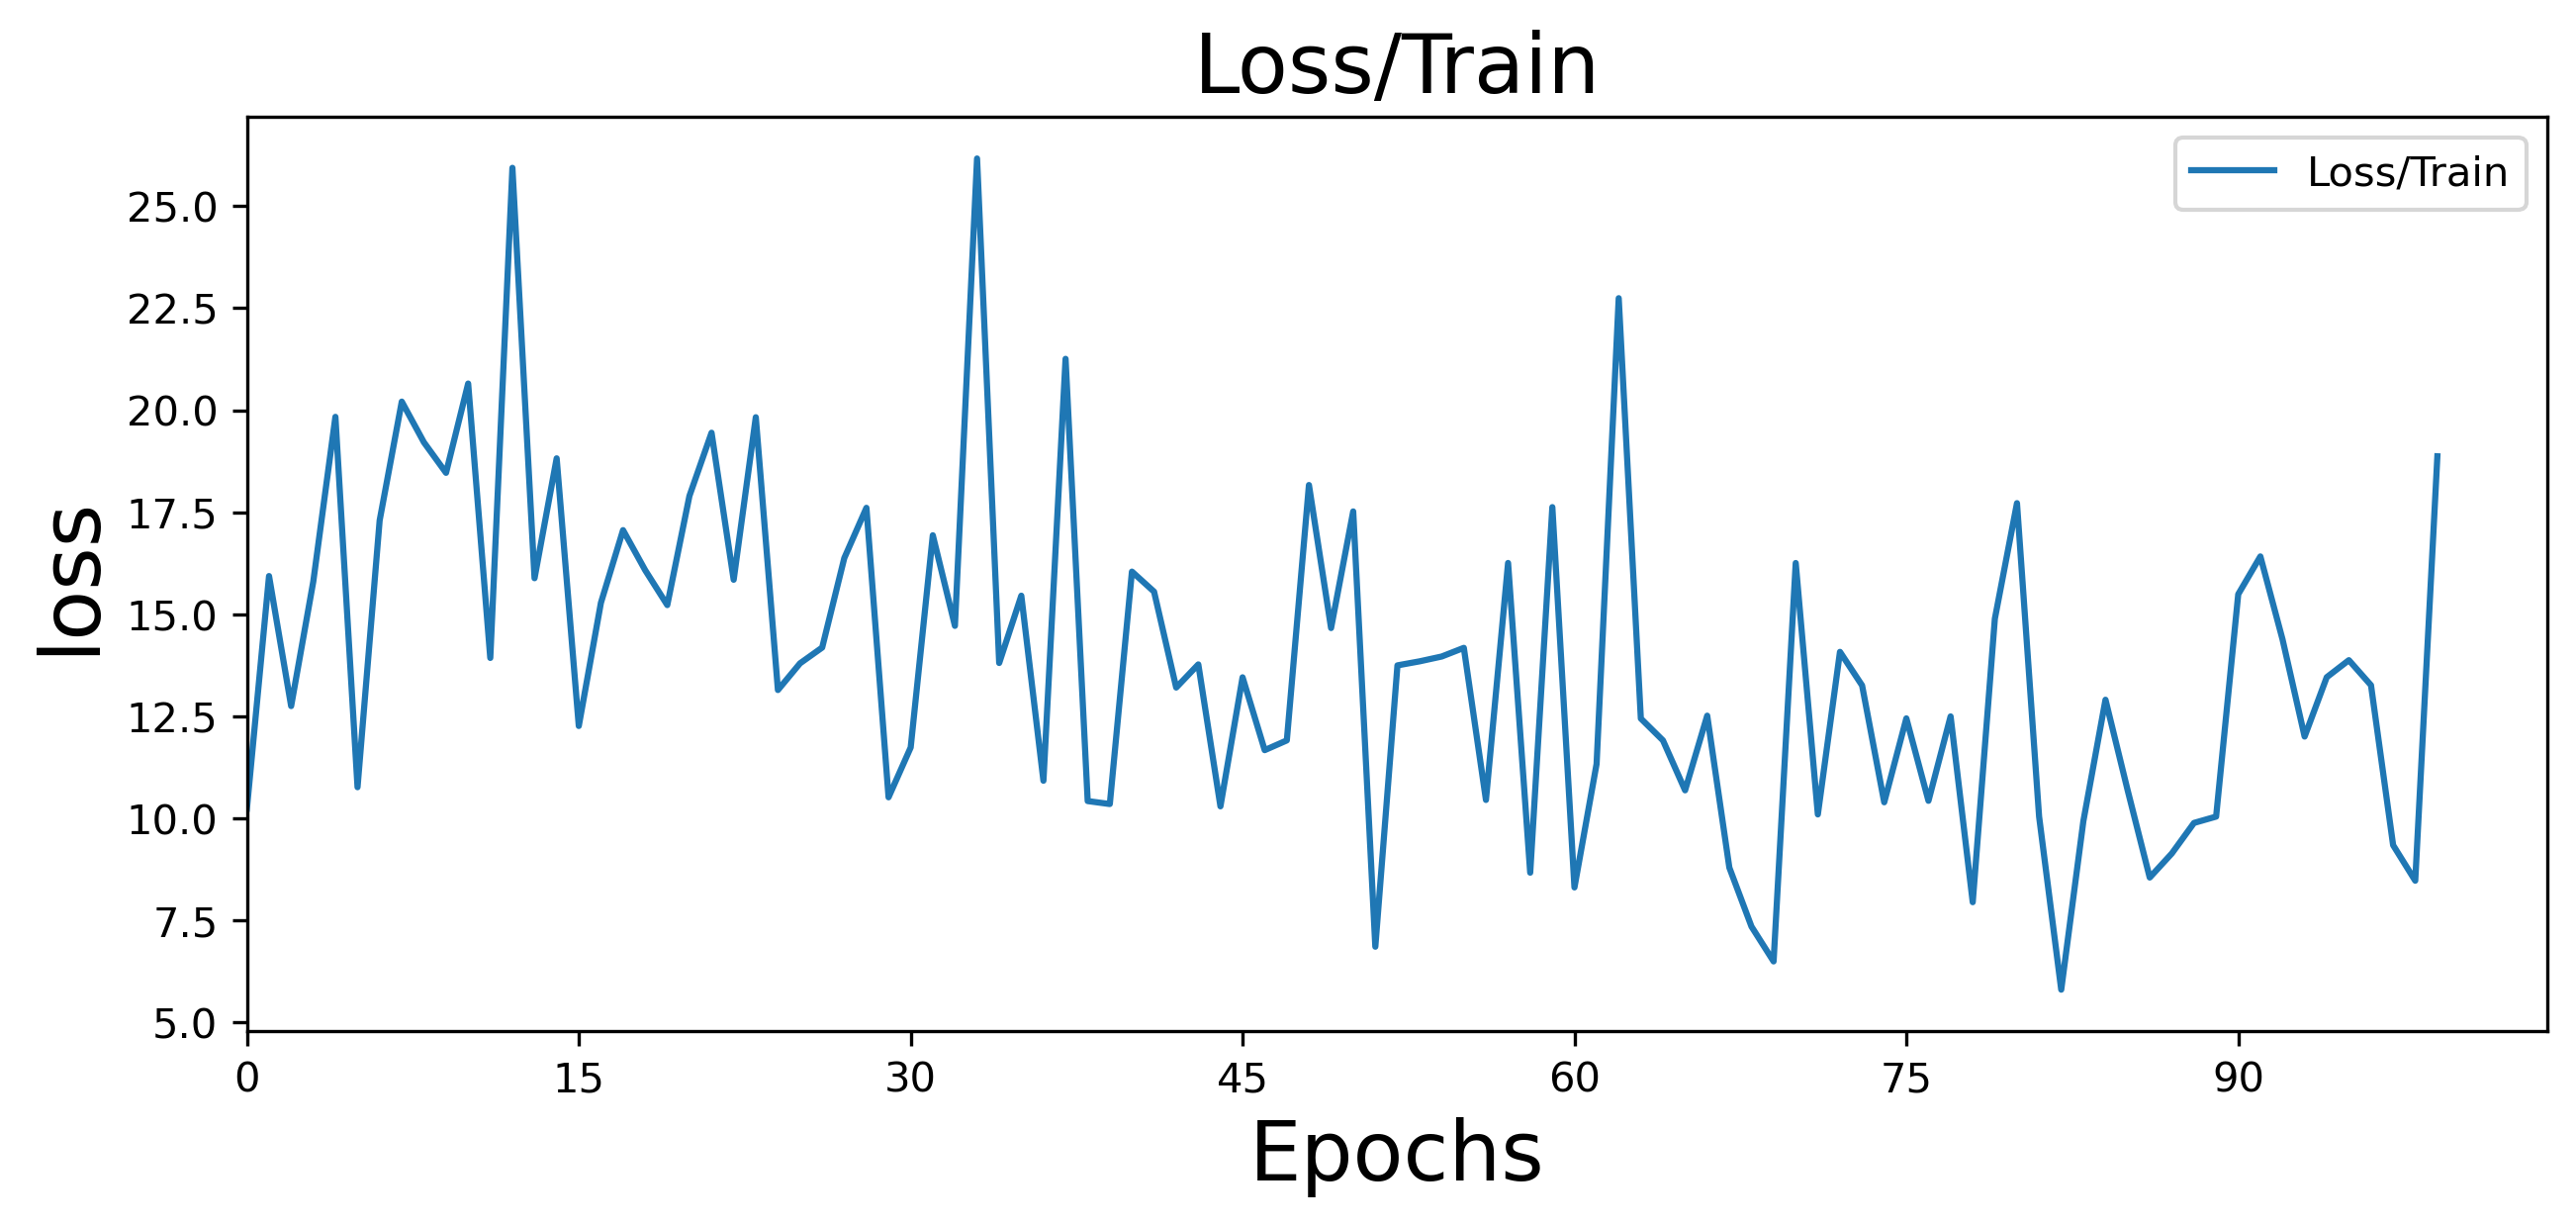

In [151]:
logger.plot_summary("Loss/Train")

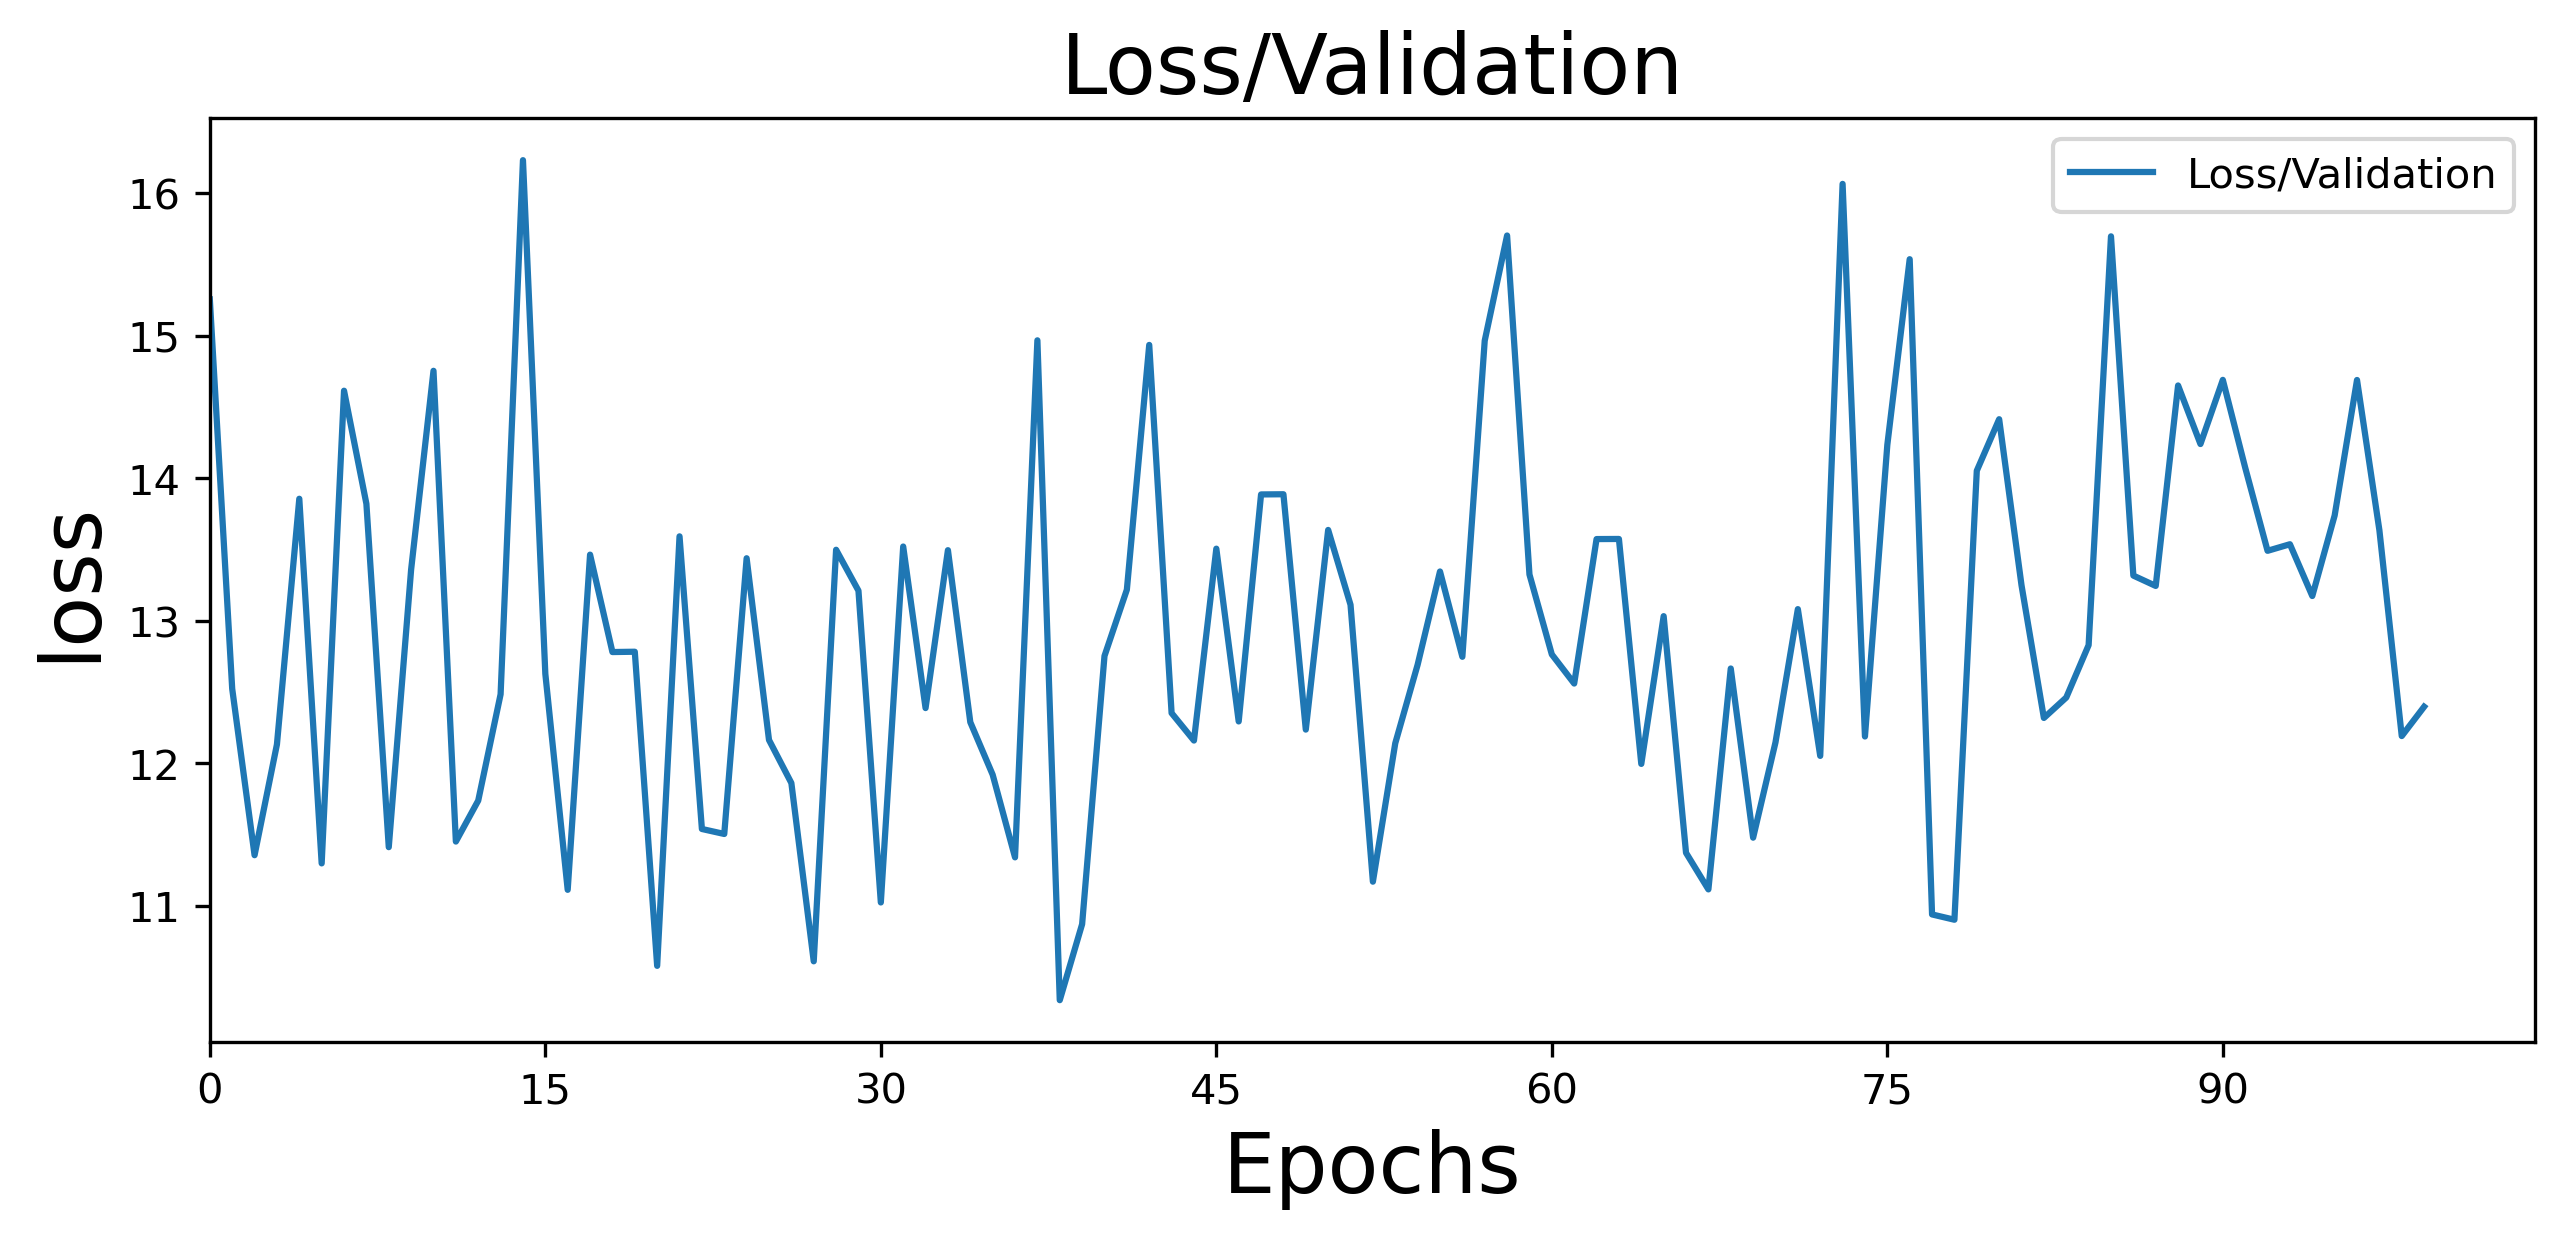

In [152]:
logger.plot_summary("Loss/Validation")

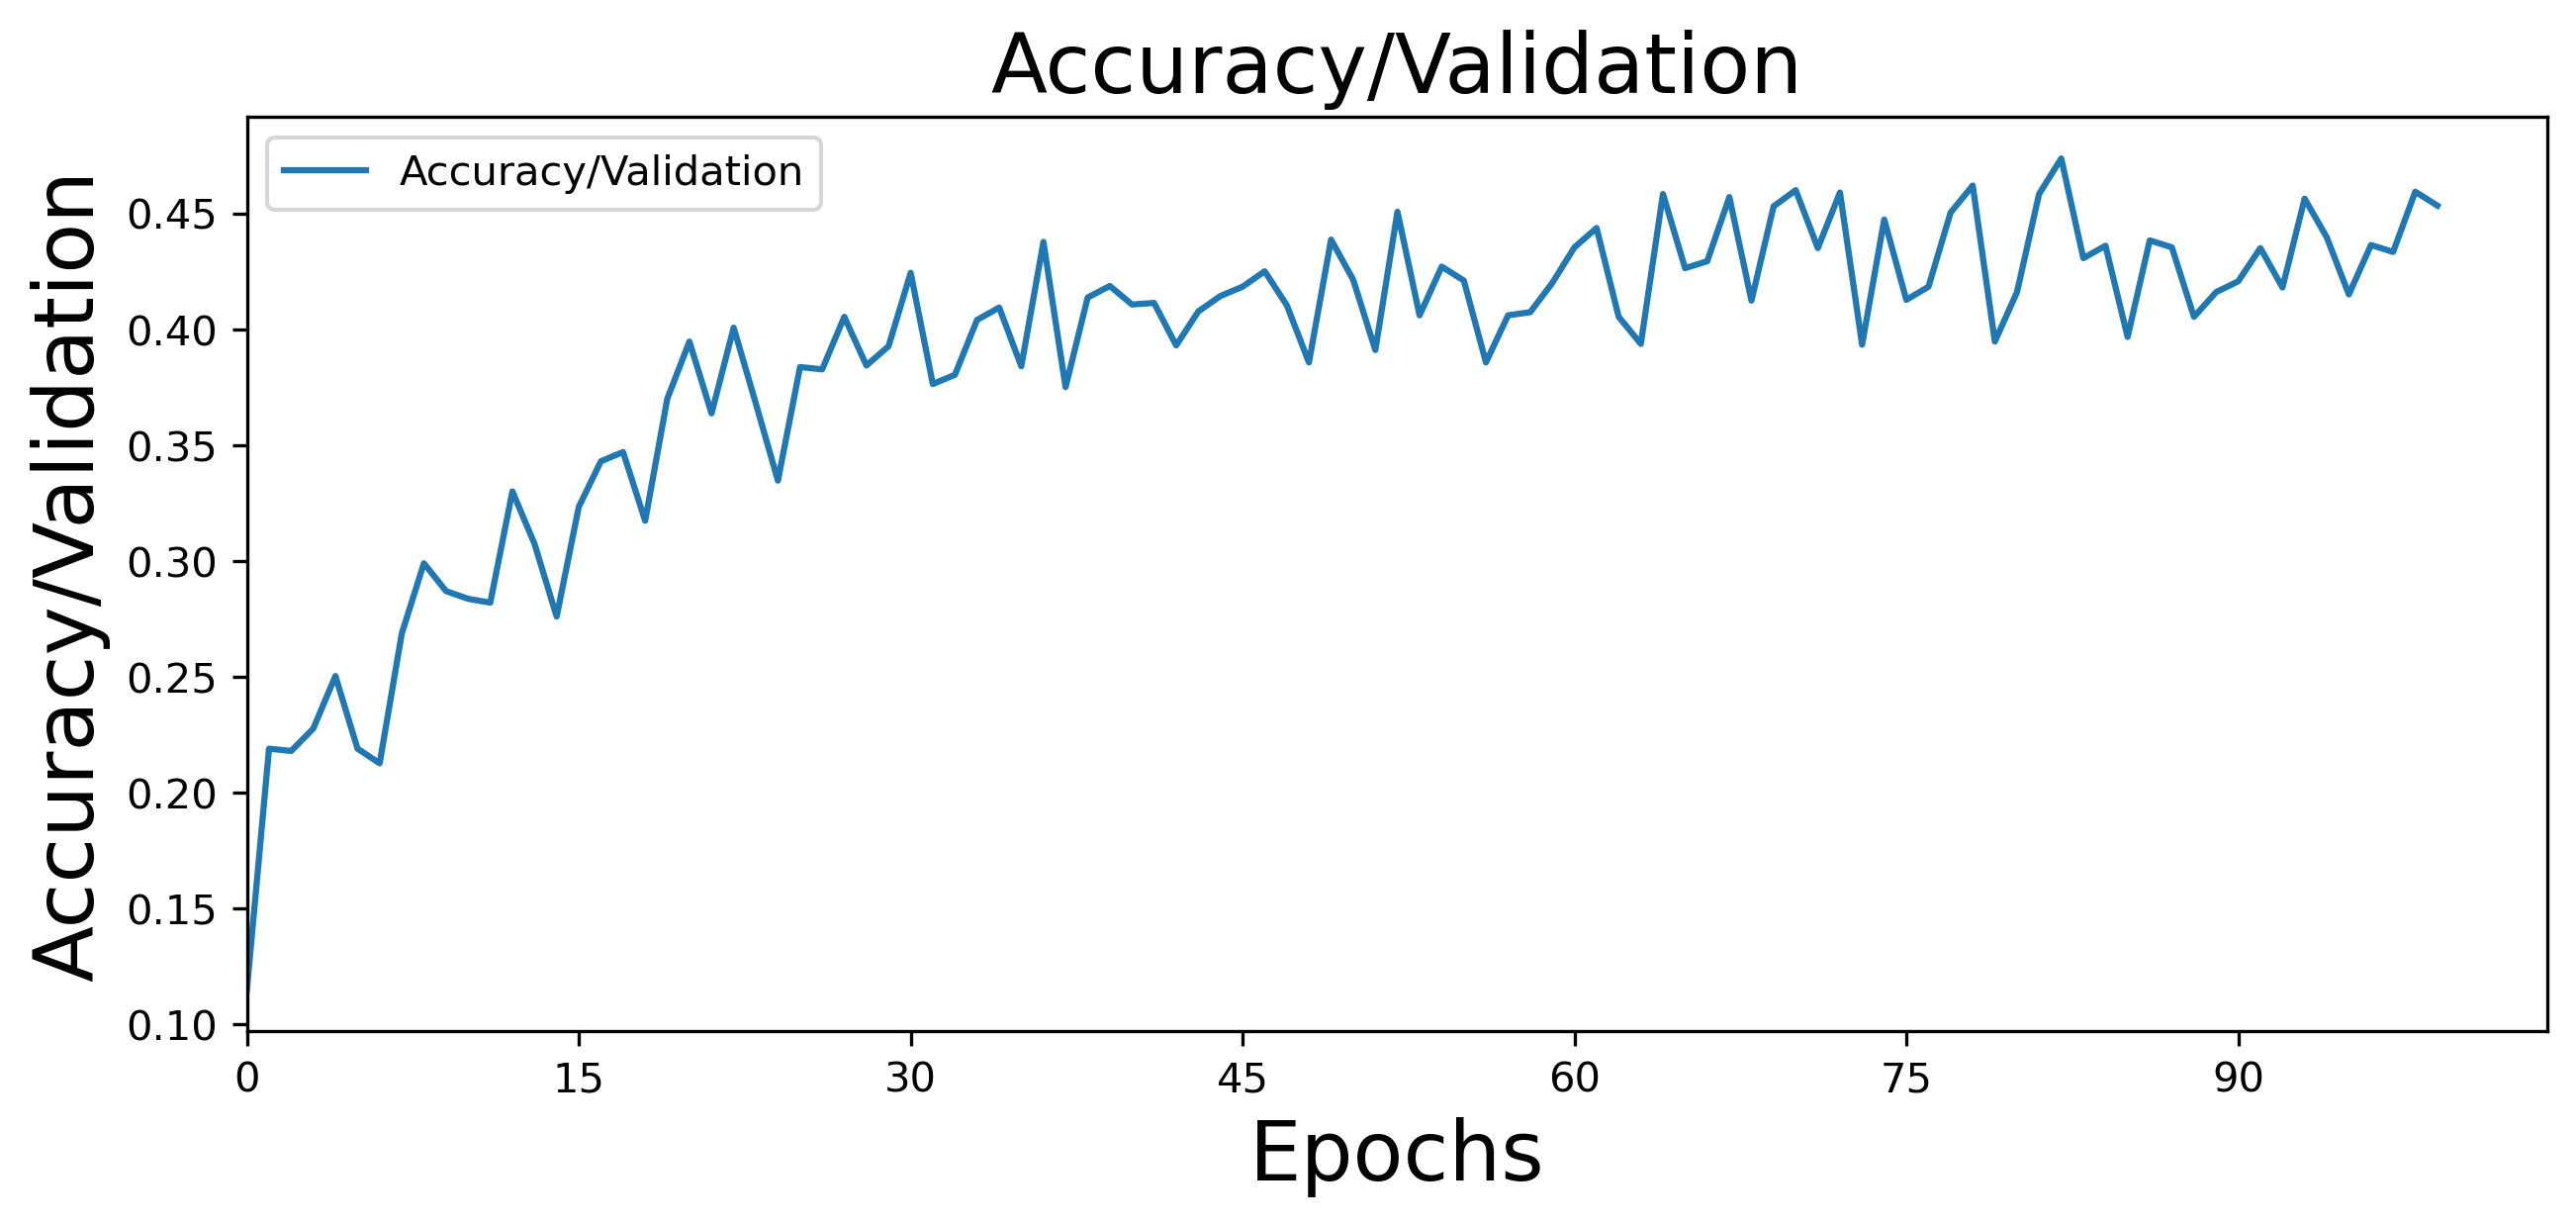

In [153]:
logger.plot_summary("Accuracy/Validation")

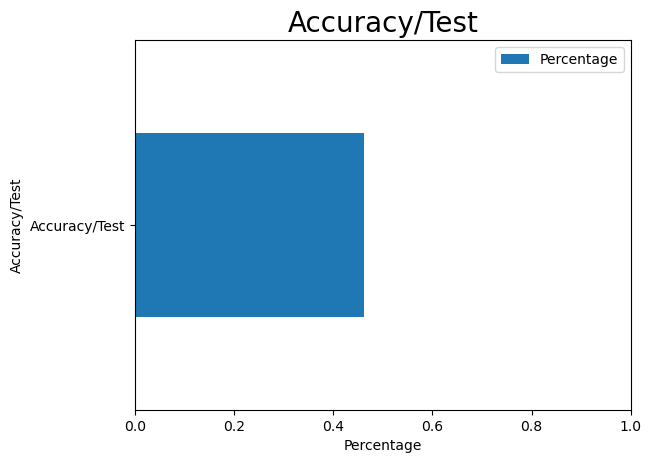

In [154]:
logger.plot_summary("Accuracy/Test")

# CUB